# TEXTBLOB ile yapılan analiz



In [ ]:
import pandas as pd
import numpy as np
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
# ML Libraries
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from textblob import TextBlob
from wordcloud import WordCloud


nltk.download('stopwords')
# Global Parameters
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
data_source="/content/drive/MyDrive/Tweets.csv"
tweets=pd.read_csv(data_source,index_col=['text','airline_sentiment'],usecols=['text','airline_sentiment'])

In [ ]:
tweets.head()

,
text,airline_sentiment
@VirginAmerica What @dhepburn said.,neutral
@VirginAmerica plus you've added commercials to the experience... tacky.,positive
@VirginAmerica I didn't today... Must mean I need to take another trip!,neutral
"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse",negative
@VirginAmerica and it's a really big bad thing about it,negative


In [ ]:
df=pd.DataFrame(tweets)
df.to_csv(r'/content/TweetsText.csv')

In [ ]:
def load_dataset(filename, cols):
  dataset=pd.read_csv(filename,encoding='UTF-8')
  dataset.columns=cols
  return dataset

In [ ]:
dataset = load_dataset("/content/TweetsText.csv", ['text','airline_sentiment'])

In [ ]:
dataset.head()

,text,airline_sentiment
0,@VirginAmerica What @dhepburn said.,neutral
1,@VirginAmerica plus you've added commercials t...,positive
2,@VirginAmerica I didn't today... Must mean I n...,neutral
3,@VirginAmerica it's really aggressive to blast...,negative
4,@VirginAmerica and it's a really big bad thing...,negative


In [ ]:
processed_features = []
def processed_feature(tweet):
  tweet.lower()
  tweet = re.sub(r"http\S+|www\S+|https\S+", '', tweet, flags=re.MULTILINE)
  # Remove user @ references and '#' from tweet
  tweet = re.sub(r'\@\w+|\#','', tweet)
  # Remove punctuations
  tweet = tweet.translate(str.maketrans('', '', string.punctuation))
  # Remove stopwords
  tweet_tokens = word_tokenize(tweet)
  filtered_words = [w for w in tweet_tokens if not w in stop_words]

  tweet = tweet.lower()
  processed_features.append(tweet)
  
  return " ".join(filtered_words)


In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
dataset.text=dataset['text'].apply(processed_feature)

In [ ]:
dataset.head()

,text,airline_sentiment
0,What said,neutral
1,plus youve added commercials experience tacky,positive
2,I didnt today Must mean I need take another trip,neutral
3,really aggressive blast obnoxious entertainmen...,negative
4,really big bad thing,negative


In [ ]:
def getSubjectivity(text):
  return TextBlob(text).sentiment.subjectivity

def getPolarity(text):
  return TextBlob(text).sentiment.polarity


In [ ]:
dataset['Subjectivity']=dataset['text'].apply(getSubjectivity)
dataset['Polarity']=dataset['text'].apply(getPolarity)

In [ ]:
dataset.head()

,text,airline_sentiment,Subjectivity,Polarity
0,What said,neutral,0.000000,0.00000
1,plus youve added commercials experience tacky,positive,0.000000,0.00000
2,I didnt today Must mean I need take another trip,neutral,0.687500,-0.31250
3,really aggressive blast obnoxious entertainmen...,negative,0.350000,0.00625
4,really big bad thing,negative,0.383333,-0.35000


<function matplotlib.pyplot.show>

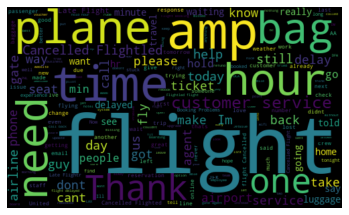

In [ ]:
allWords=''.join([twts for twts in dataset['text']])
wordCloud=WordCloud(width=500,height=300,random_state=21,max_font_size=119).generate(allWords)

plt.imshow(wordCloud,interpolation='bilinear')
plt.axis('off')
plt.show

In [ ]:
def getAnalysis(score):
  if score <0:
    return 'Negative'
  elif score==0:
    return 'Neutral'
  else:
    return 'Positive'

In [ ]:
dataset['duygu_tespiti_1']=dataset['Polarity'].apply(getAnalysis)

In [ ]:
dataset.head()

,text,airline_sentiment,Subjectivity,Polarity,duygu_tespiti_1
0,What said,neutral,0.000000,0.00000,Neutral
1,plus youve added commercials experience tacky,positive,0.000000,0.00000,Neutral
2,I didnt today Must mean I need take another trip,neutral,0.687500,-0.31250,Negative
3,really aggressive blast obnoxious entertainmen...,negative,0.350000,0.00625,Positive
4,really big bad thing,negative,0.383333,-0.35000,Negative


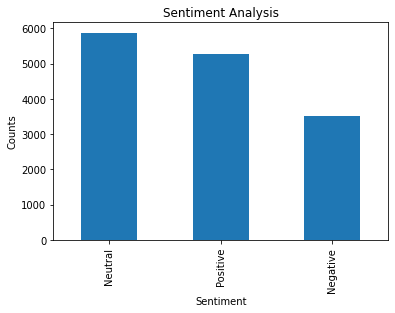

In [ ]:
dataset['duygu_tespiti_1'].value_counts()
plt.title('Sentiment Analysis')
plt.xlabel('Sentiment')
plt.ylabel('Counts')
dataset['duygu_tespiti_1'].value_counts().plot(kind='bar')
plt.show()

In [ ]:
labels = dataset.iloc[:, 4].values

In [ ]:
vectorizer=TfidfVectorizer(max_features=2500,min_df=7,max_df=0.8,stop_words=stopwords.words('english'))
processed_features=vectorizer.fit_transform(processed_features).toarray()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(processed_features, labels, test_size=0.2, random_state=0)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
text_classifier = RandomForestClassifier(n_estimators=200, random_state=0)
text_classifier.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [ ]:
predictions = text_classifier.predict(X_test)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,f1_score

print('Confusion Matrix: \n',confusion_matrix(y_test,predictions))
print('Classifiaciton: \n',classification_report(y_test,predictions))
print('Accuracy Score: \n',accuracy_score(y_test, predictions))
print('F1-Score (macro): \n',f1_score(y_test,predictions,average='macro'))
print('F1-Score (weighted): \n',f1_score(y_test,predictions,average='weighted'))

Confusion Matrix: 
 [[ 540   61   80]
 [   8 1191   17]
 [  49   72  910]]
Classifiaciton: 
               precision    recall  f1-score   support

    Negative       0.90      0.79      0.85       681
     Neutral       0.90      0.98      0.94      1216
    Positive       0.90      0.88      0.89      1031

    accuracy                           0.90      2928
   macro avg       0.90      0.89      0.89      2928
weighted avg       0.90      0.90      0.90      2928

Accuracy Score: 
 0.9019808743169399
F1-Score (macro): 
 0.8919660276055453
F1-Score (weighted): 
 0.9004673502325408


# VADER ile yapılan analiz

In [ ]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [ ]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

/usr/local/lib/python3.6/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [ ]:
sid=SentimentIntensityAnalyzer()

In [ ]:
dataset['airline_sentiment'].value_counts()

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64

In [ ]:
dataset.dropna(inplace=True)

In [ ]:
processed_features_iki = []
def processed_feature_iki(tweet):
 
  processed_features_iki.append(tweet)
  
  return tweet

In [ ]:
dataset.text=dataset['text'].apply(processed_feature_iki)

In [ ]:
sid.polarity_scores(dataset.iloc[3]['text'])

{'compound': -0.3306, 'neg': 0.345, 'neu': 0.468, 'pos': 0.187}

In [ ]:
dataset['scores']=dataset['text'].apply(lambda text:sid.polarity_scores(text))

In [ ]:
dataset.head()

,text,airline_sentiment,Subjectivity,Polarity,duygu_tespiti_1,scores
0,What said,neutral,0.000000,0.00000,Neutral,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
1,plus youve added commercials experience tacky,positive,0.000000,0.00000,Neutral,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
2,I didnt today Must mean I need take another trip,neutral,0.687500,-0.31250,Negative,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
3,really aggressive blast obnoxious entertainmen...,negative,0.350000,0.00625,Positive,"{'neg': 0.345, 'neu': 0.468, 'pos': 0.187, 'co..."
4,really big bad thing,negative,0.383333,-0.35000,Negative,"{'neg': 0.557, 'neu': 0.443, 'pos': 0.0, 'comp..."


In [ ]:
dataset['compound']=dataset['scores'].apply(lambda result:result['compound'])

In [ ]:
dataset.head()

,text,airline_sentiment,Subjectivity,Polarity,duygu_tespiti_1,scores,compound
0,What said,neutral,0.000000,0.00000,Neutral,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000
1,plus youve added commercials experience tacky,positive,0.000000,0.00000,Neutral,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000
2,I didnt today Must mean I need take another trip,neutral,0.687500,-0.31250,Negative,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000
3,really aggressive blast obnoxious entertainmen...,negative,0.350000,0.00625,Positive,"{'neg': 0.345, 'neu': 0.468, 'pos': 0.187, 'co...",-0.3306
4,really big bad thing,negative,0.383333,-0.35000,Negative,"{'neg': 0.557, 'neu': 0.443, 'pos': 0.0, 'comp...",-0.5829


In [ ]:
def analysis(score):
  if score <0:
    return 'Negative'
  elif score==0:
    return 'Neutral'
  else:
    return 'Positive'

In [ ]:
dataset['duygu_tespiti_2']=dataset['compound'].apply(analysis)

In [ ]:
dataset.head()

,text,airline_sentiment,Subjectivity,Polarity,duygu_tespiti_1,scores,compound,duygu_tespiti_2
0,What said,neutral,0.000000,0.00000,Neutral,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,Neutral
1,plus youve added commercials experience tacky,positive,0.000000,0.00000,Neutral,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,Neutral
2,I didnt today Must mean I need take another trip,neutral,0.687500,-0.31250,Negative,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,Neutral
3,really aggressive blast obnoxious entertainmen...,negative,0.350000,0.00625,Positive,"{'neg': 0.345, 'neu': 0.468, 'pos': 0.187, 'co...",-0.3306,Negative
4,really big bad thing,negative,0.383333,-0.35000,Negative,"{'neg': 0.557, 'neu': 0.443, 'pos': 0.0, 'comp...",-0.5829,Negative


In [ ]:
#features = dataset.iloc[:, 0].values
labels = dataset.iloc[:, 7].values

In [ ]:
vectorizer = TfidfVectorizer (max_features=2500, min_df=7, max_df=0.8, stop_words=stopwords.words('english'))
processed_features = vectorizer.fit_transform(processed_features_iki).toarray()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(processed_features, labels, test_size=0.2, random_state=0)

In [ ]:
text_classifier = RandomForestClassifier(n_estimators=200, random_state=0)
text_classifier.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [ ]:
predictions = text_classifier.predict(X_test)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,f1_score

print('Confusion Matrix: \n',confusion_matrix(y_test,predictions))
print('Classifiaciton: \n',classification_report(y_test,predictions))
print('Accuracy Score: \n',accuracy_score(y_test, predictions))
print('F1-Score (macro): \n',f1_score(y_test,predictions,average='macro'))
print('F1-Score (weighted): \n',f1_score(y_test,predictions,average='weighted'))

Confusion Matrix: 
 [[ 697  104  135]
 [  28  661   16]
 [ 138  102 1047]]
Classifiaciton: 
               precision    recall  f1-score   support

    Negative       0.81      0.74      0.77       936
     Neutral       0.76      0.94      0.84       705
    Positive       0.87      0.81      0.84      1287

    accuracy                           0.82      2928
   macro avg       0.81      0.83      0.82      2928
weighted avg       0.83      0.82      0.82      2928

Accuracy Score: 
 0.8213797814207651
F1-Score (macro): 
 0.819499262416743
F1-Score (weighted): 
 0.8205815585683027


# FLAIR ile yapılan analiz

In [ ]:
pip install flair

     |████████████████████████████████| 450kB 5.7MB/s 
     |████████████████████████████████| 983kB 21.8MB/s 
     |████████████████████████████████| 71kB 6.6MB/s 
     |████████████████████████████████| 798kB 21.5MB/s 
     |████████████████████████████████| 19.7MB 7.9MB/s 
     |████████████████████████████████| 1.1MB 43.0MB/s 
     |████████████████████████████████| 1.3MB 44.0MB/s 
     |████████████████████████████████| 890kB 36.5MB/s 
     |████████████████████████████████| 2.9MB 40.9MB/s 
  Created wheel for langdetect: filename=langdetect-1.0.8-cp36-none-any.whl size=993194 sha256=8af27dc34747521d08e460737dcab314a6a23499eea68553a01a6c03ebee162f
  Stored in directory: /root/.cache/pip/wheels/8d/b3/aa/6d99de9f3841d7d3d40a60ea06e6d669e8e5012e6c8b947a57
  Created wheel for segtok: filename=segtok-1.5.10-cp36-none-any.whl size=25019 sha256=89feed54f78dc9c64fba1f6c6d4cc436760ca369bfaf10f62d9c323cc33be762
  Stored in directory: /root/.cache/pip/wheels/b4/39/f6/9ca1c5cabde964d728023b57

In [ ]:
from flair.models import TextClassifier
from flair.data import Sentence
import flair
from segtok.segmenter import split_single

classifier = TextClassifier.load('en-sentiment')

2021-01-04 21:58:46,702 https://nlp.informatik.hu-berlin.de/resources/models/sentiment-curated-distilbert/sentiment-en-mix-distillbert_3.1.pt not found in cache, downloading to /tmp/tmpf6t57qc7


100%|██████████| 266147697/266147697 [00:52<00:00, 5091168.60B/s]

2021-01-04 21:59:39,330 copying /tmp/tmpf6t57qc7 to cache at /root/.flair/models/sentiment-en-mix-distillbert_3.1.pt


2021-01-04 21:59:40,061 removing temp file /tmp/tmpf6t57qc7
2021-01-04 21:59:40,099 loading file /root/.flair/models/sentiment-en-mix-distillbert_3.1.pt


In [ ]:
def make_sentences(text):

  """ Break apart text into a list of sentences """
  sentences = [sent for sent in split_single(text)]
  return sentences

In [ ]:
def predict(sentence):
  """ Predict the sentiment of a sentence """
  if sentence == "":
    return 0
  text = Sentence(sentence)
  # stacked_embeddings.embed(text)
  classifier.predict(text)
  value = text.labels[0].to_dict()['value'] 
  if value == 'POSITIVE':
    result = text.to_dict()['labels'][0]['confidence']
  else:
    result = -(text.to_dict()['labels'][0]['confidence'])
  return round(result, 3)

In [ ]:
def get_scores(sentences):
  """ Call predict on every sentence of a text """
  results = []
    
  for i in range(0, len(sentences)): 
    results.append(predict(sentences[i]))

  return results


In [ ]:
def get_sum(scores):
  result = round(sum(scores), 3)
  return result

In [ ]:
dataset['sentences']=dataset.text.apply(make_sentences)

In [ ]:
dataset['score']=dataset['sentences'].apply(get_scores)

In [ ]:
dataset['scores_sum']=dataset.score.apply(get_sum)

In [ ]:
dataset['duygu_tespiti_3']=dataset['scores_sum'].apply(getAnalysis)

In [ ]:
dataset.head()

,text,airline_sentiment,Subjectivity,Polarity,duygu_tespiti_1,scores,compound,duygu_tespiti_2,sentences,score,scores_sum,duygu_tespiti_3
0,What said,neutral,0.000000,0.00000,Neutral,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,Neutral,[What said],[0.995],0.995,Positive
1,plus youve added commercials experience tacky,positive,0.000000,0.00000,Neutral,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,Neutral,[plus youve added commercials experience tacky],[-0.994],-0.994,Negative
2,I didnt today Must mean I need take another trip,neutral,0.687500,-0.31250,Negative,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,Neutral,[I didnt today Must mean I need take another t...,[-0.768],-0.768,Negative
3,really aggressive blast obnoxious entertainmen...,negative,0.350000,0.00625,Positive,"{'neg': 0.345, 'neu': 0.468, 'pos': 0.187, 'co...",-0.3306,Negative,[really aggressive blast obnoxious entertainme...,[-0.989],-0.989,Negative
4,really big bad thing,negative,0.383333,-0.35000,Negative,"{'neg': 0.557, 'neu': 0.443, 'pos': 0.0, 'comp...",-0.5829,Negative,[really big bad thing],[-1.0],-1.000,Negative


In [ ]:
labels = dataset.iloc[:, 11].values

In [ ]:
vectorizer = TfidfVectorizer (max_features=2500, min_df=7, max_df=0.8, stop_words=stopwords.words('english'))
processed_features = vectorizer.fit_transform(processed_features_iki).toarray()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(processed_features, labels, test_size=0.2, random_state=0)

In [ ]:
text_classifier = RandomForestClassifier(n_estimators=200, random_state=0)
text_classifier.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [ ]:
predictions = text_classifier.predict(X_test)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,f1_score

print('Confusion Matrix: \n',confusion_matrix(y_test,predictions))
print('Classifiaciton: \n',classification_report(y_test,predictions))
print('Accuracy Score: \n',accuracy_score(y_test, predictions))
print('F1-Score (macro): \n',f1_score(y_test,predictions,average='macro'))
print('F1-Score (weighted): \n',f1_score(y_test,predictions,average='weighted'))

Confusion Matrix: 
 [[1821    0  156]
 [   0    0    2]
 [ 420    0  529]]
Classifiaciton: 
               precision    recall  f1-score   support

    Negative       0.81      0.92      0.86      1977
     Neutral       0.00      0.00      0.00         2
    Positive       0.77      0.56      0.65       949

    accuracy                           0.80      2928
   macro avg       0.53      0.49      0.50      2928
weighted avg       0.80      0.80      0.79      2928

Accuracy Score: 
 0.8025956284153005
F1-Score (macro): 
 0.5033805520872822
F1-Score (weighted): 
 0.7926035548032448


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
dataset.head()

,text,airline_sentiment,Subjectivity,Polarity,duygu_tespiti_1,scores,compound,duygu_tespiti_2,sentences,scores_sum,duygu_tespiti_3
0,What said,neutral,0.000000,0.00000,Neutral,[0.995],0.0000,Neutral,[What said],0.995,Positive
1,plus youve added commercials experience tacky,positive,0.000000,0.00000,Neutral,[-0.994],0.0000,Neutral,[plus youve added commercials experience tacky],-0.994,Negative
2,I didnt today Must mean I need take another trip,neutral,0.687500,-0.31250,Negative,[-0.768],0.0000,Neutral,[I didnt today Must mean I need take another t...,-0.768,Negative
3,really aggressive blast obnoxious entertainmen...,negative,0.350000,0.00625,Positive,[-0.989],-0.3306,Negative,[really aggressive blast obnoxious entertainme...,-0.989,Negative
4,really big bad thing,negative,0.383333,-0.35000,Negative,[-1.0],-0.5829,Negative,[really big bad thing],-1.000,Negative


# GENELLEŞTİRME

In [ ]:
df=pd.DataFrame(dataset)
df.to_csv(r'/content/TweetsAnalysis.csv',index=False)

In [ ]:
data_source="/content/TweetsAnalysis.csv"
tweets=pd.read_csv(data_source,index_col=['text','airline_sentiment','duygu_tespiti_1','duygu_tespiti_2','duygu_tespiti_3'],usecols=['text','airline_sentiment','duygu_tespiti_1','duygu_tespiti_2','duygu_tespiti_3'])

In [ ]:
df=pd.DataFrame(tweets)
df.to_csv(r'/content/TweetsDataset.csv')

In [ ]:
df.head()

,,,,
text,airline_sentiment,duygu_tespiti_1,duygu_tespiti_2,duygu_tespiti_3
What said,neutral,Neutral,Neutral,Positive
plus youve added commercials experience tacky,positive,Neutral,Neutral,Negative
I didnt today Must mean I need take another trip,neutral,Negative,Neutral,Negative
really aggressive blast obnoxious entertainment guests faces amp little recourse,negative,Positive,Negative,Negative
really big bad thing,negative,Negative,Negative,Negative


# ACCURACY score sütun grafiği

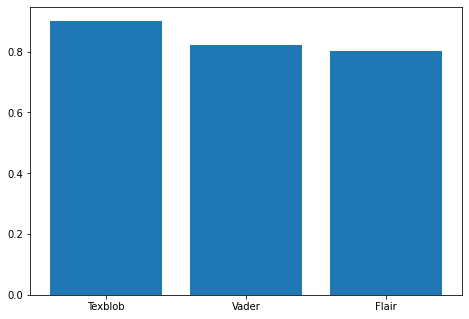

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
langs = ['Texblob', 'Vader', 'Flair']
value = [0.9019808743169399,0.8213797814207651,0.8025956284153005]
ax.bar(langs,value)
plt.show()